# Project "Vehicle Detection"

Interessante Udacitiy-Lektionen:
Project 15


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from skimage.feature import hog
from sklearn import svm, grid_search
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import cv2
import glob
import imp
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import numpy as np
import os
import pickle
import random
import time
%matplotlib inline


/Users/harald/miniconda3/envs/CarND/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/harald/miniconda3/envs/CarND/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def timestamp(tStart, msg = None):
    tNow = time.time()
    if msg is not None:
        print(msg.format(tNow-tStart))
    return tNow


def cv2mpimg(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def get_hog_features(img, orientation, pix_per_cell, cell_per_block, toVector, visualize = False):
    return hog(img,
              orientation,
              (pix_per_cell, pix_per_cell),
              (cell_per_block, cell_per_block),
              block_norm = 'L1',
              visualise = visualize,
              feature_vector = toVector)


def extract_features(img, cspace="BGR", orientation=9, pix_per_cell=8, cell_per_block=2, hogChannel=0, toVector=False, visualize=False):
    if cspace != "BGR":
        if cspace == "HSV":
            imgConv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif cspace == "LUV":
            imgConv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif cspace == "HLS":
            imgConv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif cspace == "YUV":
            imgConv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif cspace == "YCrCb":
            imgConv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else:
        imgConv = np.copy(img)
        
    if hogChannel == "ALL":
        hogFeat = []
        for channel in range(imgConv.shape[2]):
            hogFeat.append(get_hog_features(imgConv[:,:,channel], orientation, pix_per_cell, cell_per_block, visualize=visualize, toVector=toVector))
        #hogFeat = np.ravel(hogFeat)
        return hogFeat[0], hogFeat[1], hogFeat[2]
    else:
        return get_hog_features(imgConv[:,:,hogChannel], orientation, pix_per_cell, cell_per_block, visualize=visualize, toVector=toVector)


In [3]:
# Read in the training data from a pickle or create the pickle if it does not exist yet.
FORCE_READ_TRAINING_DATA = False
PICKLE_NAME_TRAIN = "./vd_training_images.p"

DEBUG=False

if FORCE_READ_TRAINING_DATA or not os.path.exists(PICKLE_NAME_TRAIN):  
    # Declare the parameter for extract_features()
    # COLORSPACE is one out of "BGR", "HSV", "LUV", "HLS", "YUV", "YCrCb"
    COLORSPACE = "YCrCb"
    # HOG_CHANNEL is one out of 0, 1, 2, "ALL"
    HOG_CHANNEL = "ALL"
    ORIENTATION = 9
    PIX_PER_CELL = 8
    CELL_PER_BLOCK = 2
    HOG_ONLY = True
    SPATIAL_SIZE=32
    HIST_BINS=32

    print("Reading training images ...")
    t0 = time.time()
    featureList = []
    labels = []

    # Read in all "car" images
    filenames =  [(n, 1) for n in glob.glob("training_data/cars/*/*")]
    filenames += [(n, 0) for n in glob.glob("training_data/notcars/*/*")]
    for i in range(10):
        random.shuffle(filenames)

    for fn in filenames:
        img = cv2.imread(fn[0])
        hogFeatures = extract_features(img, 
                                       cspace=COLORSPACE, 
                                       orientation=ORIENTATION, 
                                       pix_per_cell=PIX_PER_CELL, 
                                       cell_per_block=CELL_PER_BLOCK,
                                       hogChannel=HOG_CHANNEL,
                                       toVector = True, 
                                       visualize = False)
        if HOG_ONLY:
            hogFeatures = np.hstack((hogFeatures)).reshape(1, -1)
            featureList.append(hogFeatures)
        else:
            hogFeatures = np.hstack((hogFeatures))
            subimg = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            spatFeat = bin_spatial(subimg, (SPATIAL_SIZE, SPATIAL_SIZE))
            histFeat = color_hist(subimg, nbins=HIST_BINS)
            featureList.append(np.hstack((hogFeatures, spatFeat, histFeat)).reshape(1, -1))
        
        labels.append(fn[1])

    X = np.vstack(featureList).astype(np.float64)
    if not HOG_ONLY:
        X_scaler = StandardScaler().fit(X)
        X = X_scaler.transform(X)        

    print("Reading trainig data took {:5.3f} seconds".format(time.time() - t0))

    # Save training data
    dist_pickle = {}
#    dist_pickle["featureList"] = featureList
    dist_pickle["X"] = X
    dist_pickle["labels"] = labels
    dist_pickle["COLORSPACE"] = COLORSPACE
    dist_pickle["HOG_CHANNEL"] = HOG_CHANNEL
    dist_pickle["ORIENTATION"] = ORIENTATION
    dist_pickle["PIX_PER_CELL"] = PIX_PER_CELL
    dist_pickle["CELL_PER_BLOCK"] = CELL_PER_BLOCK
    dist_pickle["HOG_ONLY"] = HOG_ONLY
    dist_pickle["SPATIAL_SIZE"] = SPATIAL_SIZE
    dist_pickle["HIST_BINS"] = HIST_BINS
    if not HOG_ONLY:
        dist_pickle["X_scaler"] = X_scaler

    pickle.dump(dist_pickle, open(PICKLE_NAME_TRAIN, "wb"))
    print("Training data saved.")
else:
    print("Loading training data ...")
    trainData = pickle.load(open(PICKLE_NAME_TRAIN, "rb"))
#    featureList = trainData['featureList']
    X = trainData['X']
    labels = trainData['labels']
    COLORSPACE = trainData["COLORSPACE"]
    HOG_CHANNEL = trainData["HOG_CHANNEL"]
    ORIENTATION = trainData["ORIENTATION"]
    PIX_PER_CELL = trainData["PIX_PER_CELL"]
    CELL_PER_BLOCK = trainData["CELL_PER_BLOCK"]
    HOG_ONLY = trainData["HOG_ONLY"]
    SPATIAL_SIZE = trainData["SPATIAL_SIZE"]
    HIST_BINS = trainData["HIST_BINS"]
    if not HOG_ONLY:
        X_scaler = trainData["X_scaler"]
    print("Training data loaded.")

Loading training data ...
Training data loaded.


In [4]:
# Read in the classifier from a pickle or create the pickle if it does not exist yet.

#
FORCE_TRAINING_CLF = False
PICKLE_NAME_CLF = "./vd_clf.p"

if os.path.exists(PICKLE_NAME_CLF) and not FORCE_TRAINING_CLF:  
    print("Loading classifier data ...")
    trainData = pickle.load(open(PICKLE_NAME_CLF, "rb"))
    clf = trainData['clf']
    print("Classifier data loaded.")

else:
    print("Training the SVM classifier ...")

    print("len(X):", len(X), " len(labels):", len(labels), "  mean(labels):", np.mean(np.array(labels)))
    X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=np.random.randint(0,100))    
    print("X_train.shape:", X_train.shape, "  y_train.shape:", y_train.shape)
    print("X_test.shape:", X_test.shape, "  y_test.shape:", y_test.shape)

    t0 = timestamp(0)

    if False:
        parameters = {"kernel": ("linear", "rbf"), "C": (1, 10)}
        svr = svm.SVC()
        clf = grid_search.GridSearchCV(svr, parameters)
        clf.fit(X_train, y_train)

        print("Training the classifier with different parameters")
        print("clf.best_params_:", clf.best_params_)
    else:
    #    clf = svm.SVC(kernel="rbf", C=10)
        clf = svm.SVC(kernel="linear", C=10)
        clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test) 
    acc = accuracy_score(y_test, y_pred)
    timestamp(t0, "Training the SVM classifier took {:.3f}")
    print("accuracy:", acc)

    # Save training data
    dist_pickle = {}
    dist_pickle["clf"] = clf
    pickle.dump(dist_pickle, open(PICKLE_NAME_CLF, "wb"))
    print("Classifier saved.")

Loading classifier data ...
Classifier data loaded.


/Users/harald/miniconda3/envs/CarND/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


hog.shape: (7, 78, 2, 2, 9)
blocks_per_win: 7
blocks  y: 7   x: 78
steps  y: 0   x: 35
rect: left: 800  top: 0  win: 128
rect: left: 832  top: 0  win: 128
rect: left: 1120  top: 0  win: 128


True

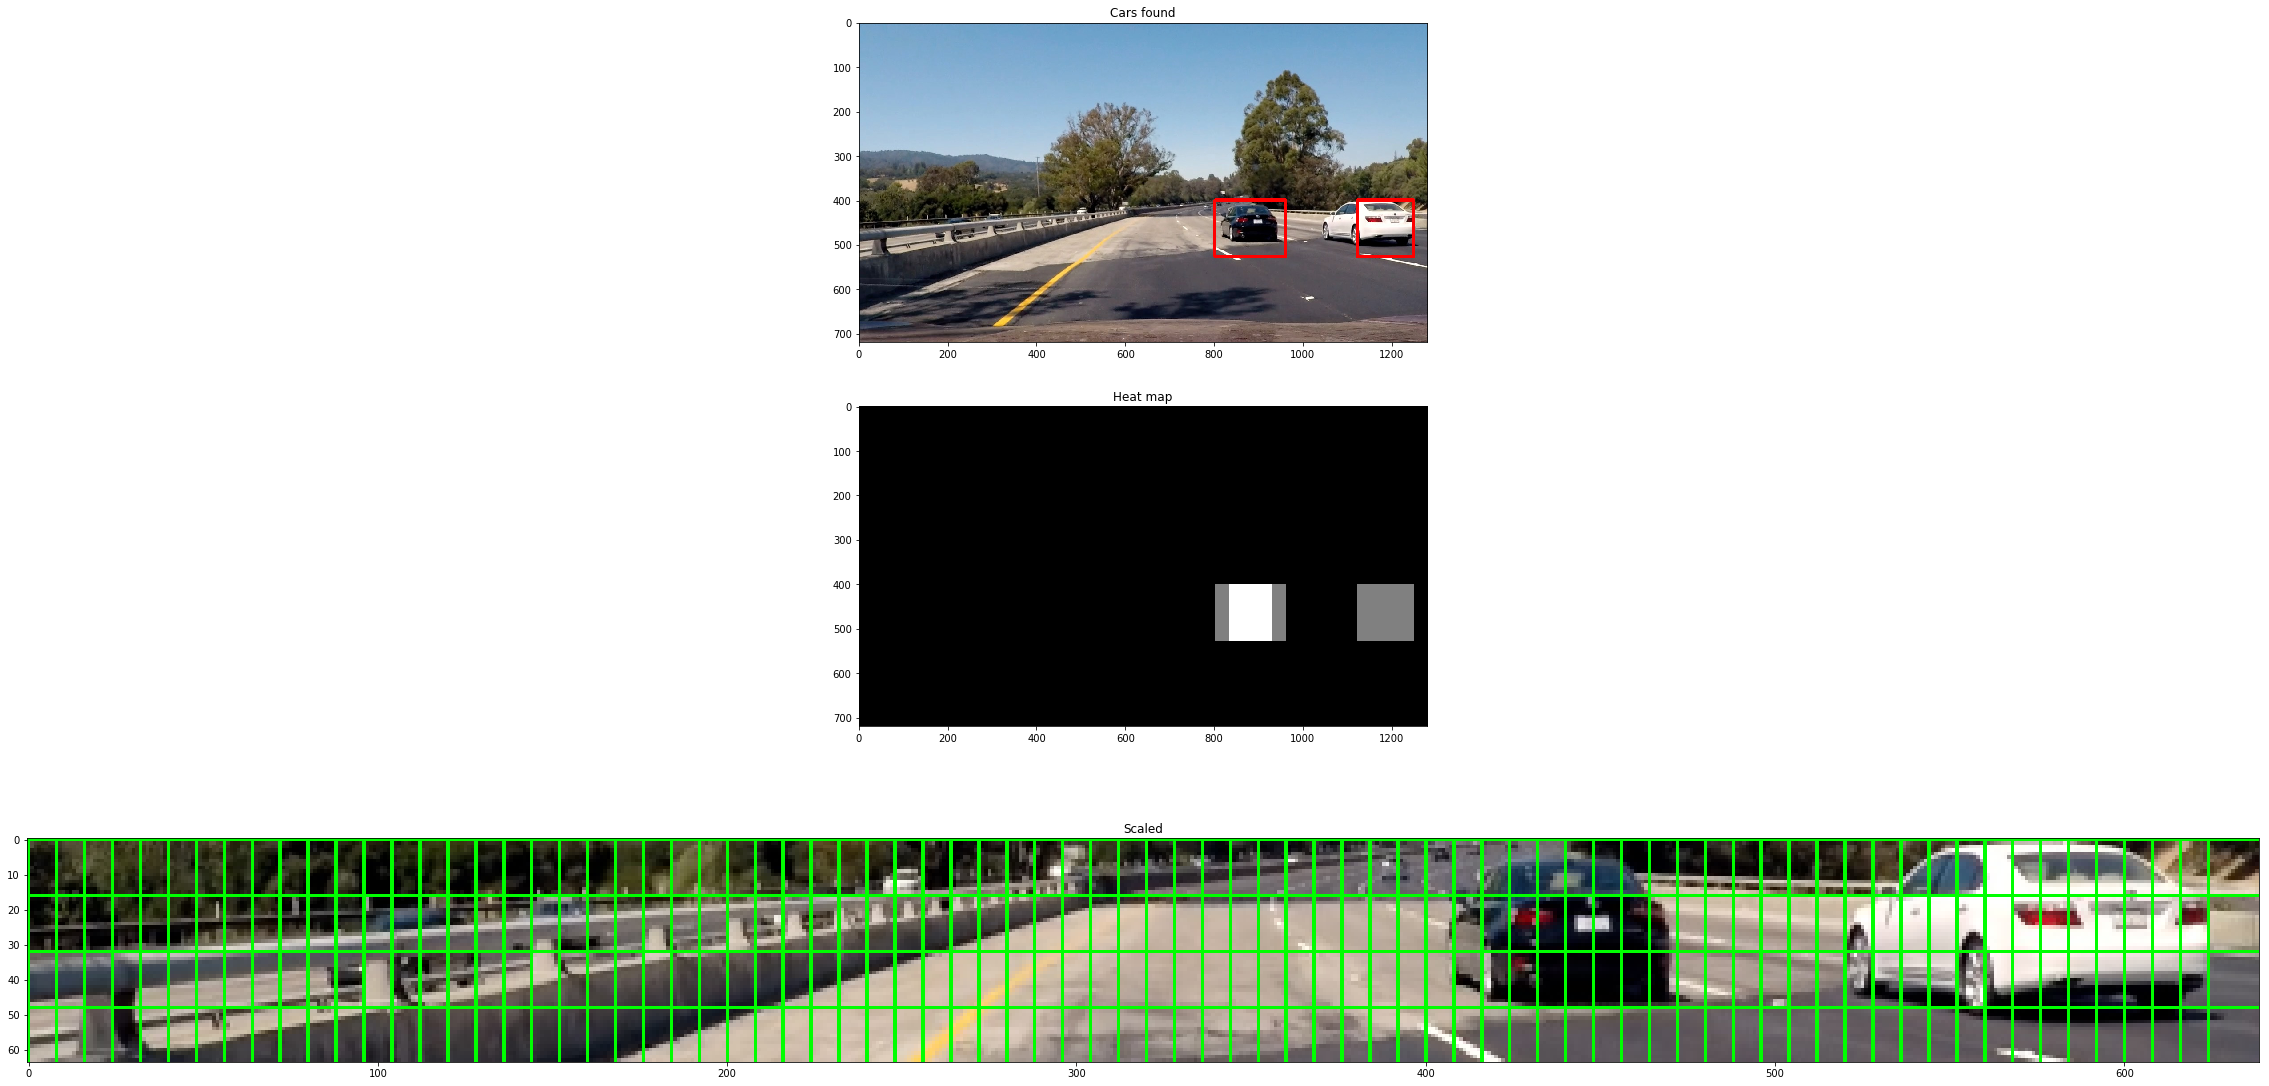

In [26]:
IMAGE_FILE = "test_images/test4.jpg"
winPosStep = 16
# -------------> SCALE, (Y_TOP, Y_BOTTOM), (X_LEFT, X_RIGHT), COLOR
SEARCH_AREAS = [#(  1.0,   (380, 492),       (0,1279), (0,0,255))
                #(  1.5,   (380, 548),       (0,1279), (0,255,255))
                (  2.0,   (400, 528),       (0,1279), (0,255,0))
                #(  2.5,   (380, 660),       (0,1279), (255,255,0))
                #(  3.0,   (380, 668),       (0,1279), (255,0,0))

                #(  1.5,   (400,656),       (0,1279))

               ]
BATCH_MODE = False
USE_HEAT_MAP = True;

def findCars(img, winStep, HOG_ONLY):
    tFu = timestamp(0)
    imgSearchWins = np.copy(img)

    blocks_per_win = PIX_PER_CELL - CELL_PER_BLOCK +1
    
#    print("PIX_PER_CELL:", PIX_PER_CELL, 
#          "  CELL_PER_BLOCK:", CELL_PER_BLOCK,
#          "  block_per_win:", blocks_per_win
#         )

    foundPosList2 = []

    for SCALE, yLimits, xLimits, COLOR in SEARCH_AREAS:
        t0 = timestamp(0)

        cells_per_step = 2
        realWinSize = int(64 * SCALE)
        realCellSize = realWinSize / PIX_PER_CELL
#        print("SCALE:", SCALE, " yLimits:", yLimits, " xLimits:", xLimits, "realWinSize:", realWinSize)
        
        imgCropped = img[yLimits[0]:yLimits[1], xLimits[0]:xLimits[1],:]
        if SCALE != 1:
            imgScaledWidth  = int(imgCropped.shape[1]/SCALE)
            imgScaledHeight = int(imgCropped.shape[0]/SCALE)
            imgScaled = cv2.resize(imgCropped,(imgScaledWidth, imgScaledHeight))
        else:
            imgScaled = np.copy(imgCropped)
#        print("imgScaled.shape:", imgScaled.shape)

        hogFeat = extract_features(imgScaled, 
                                   cspace=COLORSPACE, 
                                   orientation=ORIENTATION, 
                                   pix_per_cell=PIX_PER_CELL, 
                                   cell_per_block=CELL_PER_BLOCK,
                                   hogChannel=HOG_CHANNEL,
                                   toVector=False,
                                   visualize=False)
#        print("type(hogFeat):", type(hogFeat))
#        print("type(hogFeat[0]):", type(hogFeat[0]))
#        print("hogFeat[0].shape:", hogFeat[0].shape)

        hog0 = hogFeat[0]
        nxblocks, nyblocks = hog0.shape[1], hog0.shape[0]
        nxsteps = (nxblocks - blocks_per_win) // cells_per_step
        nysteps = (nyblocks - blocks_per_win) // cells_per_step

        if True:
            #print("hogImg.shape:", imgHog.shape)
            print("hog.shape:", hog0.shape)
            print("blocks_per_win:", blocks_per_win)
            print("blocks  y:", nyblocks, "  x:", nxblocks)
            print("steps  y:", nysteps, "  x:", nxsteps)

        featureList2 = []
        winPosList2 = []
        
        for xc in range(nxsteps+1):
            xCell = xc * cells_per_step
            xLeft = xCell * PIX_PER_CELL
#            print("xCell:", xCell, " xLeft:", xLeft)

            for yc in range(nysteps+1):
                yCell = yc * cells_per_step
                yTop  = yCell * PIX_PER_CELL
#                print("yCell:", yCell, " yTop:", yTop)

                winPosList2.append((xLeft, yTop))
                hog1Feat = hogFeat[0][yCell:yCell+blocks_per_win, xCell:xCell+blocks_per_win].ravel()
                hog2Feat = hogFeat[1][yCell:yCell+blocks_per_win, xCell:xCell+blocks_per_win].ravel()
                hog3Feat = hogFeat[2][yCell:yCell+blocks_per_win, xCell:xCell+blocks_per_win].ravel()
#                hogFeat = np.hstack((hog1Feat, hog2Feat, hog3Feat))
                if HOG_ONLY:
#                    feat = np.hstack((hogFeat)).reshape(1, -1)
                    feat = np.hstack((hog1Feat, hog2Feat, hog3Feat)).reshape(1, -1)
                else:
                    subimg = cv2.resize(imgScaled[yTop:yTop+64, xLeft:xLeft+64], (64,64))
                    subimg = cv2.cvtColor(subimg, cv2.COLOR_BGR2YCrCb)
                    spatFeat = vehicle_detection.bin_spatial(subimg, (32, 32))
                    histFeat = vehicle_detection.color_hist(subimg, nbins=32)
                    feat = np.hstack((hog1Feat, hog2Feat, hog3Feat, spatFeat, histFeat)).reshape(1, -1)
                
                if BATCH_MODE:
                    featureList2.append(feat)
                else:
                    if not HOG_ONLY:
                        testFeat = X_scaler.transform(feat)
                    else:
                        testFeat = np.copy(feat)
                    testPred = clf.predict(testFeat)
                    if testPred != 0:
                        xBoxLeft = np.int(xLeft * SCALE)
                        yTopDraw = np.int(yTop * SCALE)
                        winDraw = np.int(64*SCALE)
                        print("rect: left:", xBoxLeft, " top:", yTopDraw, " win:", winDraw)
                        car = ((xBoxLeft, yTopDraw+yLimits[0]), (realWinSize, realWinSize))
                        foundPosList2.append(car)
                    
#                print("cell x:", xCell, " y:", yCell, " -> pos x:", xLeft, " y:", yTop)
                if True:
                    yTopOrig = int(yTop*SCALE + yLimits[0])
                    cv2.line(imgSearchWins, (xLimits[0], yTopOrig), (xLimits[1], yTopOrig), COLOR) #(255, 0, 0), 3)
                    cv2.line(imgScaled,    (0, int(yTop)), (imgScaled.shape[1], int(yTop)), COLOR) #(255, 0, 0), 3)

                    for i in range(1,8):
                        cv2.line(imgSearchWins, (xLimits[0], yTopOrig+8*i), (xLimits[1], yTopOrig+8*i), COLOR) #(0, 255,255))
                        cv2.line(imgScaled, (0, int(yTop+realCellSize*i)), (imgScaled.shape[1], int(yTop+realCellSize*i)), COLOR) #(0, 255,255))

                    cv2.line(imgSearchWins, (xLimits[0], int(yTopOrig+realWinSize)), (xLimits[1], int(yTopOrig+realWinSize)), COLOR) #(0, 0,255), 3)
                    cv2.line(imgScaled, (0, int(yTop)+64), (imgScaled.shape[1], int(yTop)+64), COLOR) #(0, 0,255), 3)
            if True:
                xLeftOrig = int(xLeft*SCALE + xLimits[0])
                cv2.line(imgSearchWins, (xLeftOrig, yLimits[0]), (xLeftOrig, yLimits[1]), COLOR) #(255, 0, 0), 3)
                cv2.line(imgScaled,     (xLeft, 0), (xLeft, imgScaled.shape[0]),          COLOR) #(255, 0, 0), 3)

                for i in range(1,8):
                    cv2.line(imgSearchWins, (int(xLeftOrig+realCellSize*i), yLimits[0]), (int(xLeftOrig+realCellSize*i), yLimits[1]), COLOR) #(0, 255,255))
                    cv2.line(imgScaled,     (xLeft+8*i, 0), (xLeft+8*i, imgScaled.shape[0]), COLOR) #(0, 255,255))

                cv2.line(imgSearchWins, (int(xLeftOrig+realWinSize), yLimits[0]), (int(xLeftOrig+realWinSize), yLimits[1]), COLOR) #(0, 0,255), 3)
                cv2.line(imgScaled,     (xLeft+64, 0), (xLeft+64, imgScaled.shape[0]), COLOR) #(0, 0,255), 3)

        if BATCH_MODE:
#            t0 = timestamp(t0, "Start batch after {:.3f}s")

            X_scan2 = np.vstack(featureList2).astype(np.float64)
            if not HOG_ONLY:
                X_scan2 = X_scaler.transform(X_scan2)    
                #print("X_scan_scaled.shape:", X_scan_scaled.shape, "  X_scan_scaled:", X_scan_scaled)
            y_scan2 = clf.predict(X_scan2)
            idxFound2 = np.nonzero(y_scan2)[0]
            foundPosList2 = [(np.array(winPosList2[i])*SCALE+np.array((0, yLimits[0])), 
                              (realWinSize, realWinSize)) for i in idxFound2]
#            t0 = timestamp(t0, "Batch done after {:.3f}s")

        cv2.putText(imgSearchWins, "Scale: {:4.2}x".format(SCALE), (50,50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255))
#    timestamp(tFu, "Return after {:.3f}s")

    return foundPosList2, imgSearchWins, imgScaled

def drawHeatMap(heatMap, foundCars):
    for (foundX, foundY), (winDimX, winDimY) in foundCars:
        left = int(foundX)
        top = int(foundY)
        right = min(left+winDimX, heatMap.shape[1])
        bottom = min(top+winDimY, heatMap.shape[0])
        heatMap[top:bottom, left:right] += 1
    return heatMap

def applyThreshold(heatMap, threshold):
    heatMap[heatMap < threshold] = 0
    return heatMap
    

###################################################
# Load the image
t0 = timestamp(0)
img = cv2.imread(IMAGE_FILE)
timestamp("image read at {:f}")
foundCars, imgSearchWins, imgScaled = findCars(img, winPosStep, HOG_ONLY=HOG_ONLY)
#foundCars, imgSearchWins, imgHog = findCars(img, winPosStep)

timestamp("Cars found at {:f}")


imgPlt = np.copy(img)

if USE_HEAT_MAP:
    heatMap = np.zeros_like(img[:,:,0])
    heatMap = drawHeatMap(heatMap, foundCars)
    #heatMap = applyThreshold(heatMap, 0)

    labels = label(np.copy(heatMap))
#    print("labels found:", labels[1])
    for carNum in range(1, labels[1]+1):
        nonzero = (labels[0] == carNum).nonzero()
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(imgPlt, bbox[0], bbox[1], (0,0,255), 6)
else:
    for (foundX, foundY), (winDimX, winDimY) in foundCars:
        left = int(foundX)
        top = int(foundY)
        right = min(left+winDimX, imgPlt.shape[1])
        bottom = min(top+winDimY, imgPlt.shape[0])
        cv2.rectangle(imgPlt, (left, top), (right, bottom), (0,0,255), 6)
    timestamp("Heat map done at {:f}")


f, sub = plt.subplots(3, 1, figsize=(40,20))
sub[0].imshow(bgr2rgb(imgPlt))
sub[0].set_title("Cars found")
if USE_HEAT_MAP:
    sub[1].imshow(heatMap, cmap="gray")
#    sub[1].imshow(labels[0], cmap="gray")
    sub[1].set_title("Heat map")
else:
    sub[1].imshow(bgr2rgb(imgSearchWins))
    sub[1].set_title("Search windows")

#sub[2].imshow(bgr2rgb(imgSearchWins))
#sub[2].set_title("Search windows")


sub[2].imshow(bgr2rgb(imgScaled))
sub[2].set_title("Scaled")

cv2.imwrite("./output_images/"+os.path.basename(IMAGE_FILE), imgPlt)
cv2.imwrite("./output_images/search_"+os.path.basename(IMAGE_FILE), imgSearchWins)


In [7]:
# Select the video: "project" or "test"
videoName = "project"

PICKLE_NAME_CARS = "./vd_cars_{:s}.p".format(videoName)

videoReader = cv2.VideoCapture("{:s}_video.mp4".format(videoName))
#videoWriter = cv2.VideoWriter("./output_images/{:s}_video.mp4".format(videoName), cv2.VideoWriter_fourcc(*'mp4v') , 25.0, (1280,720))
#if not videoWriter.isOpened():
#    print("ERROR: Could not open VideoWriter")
#    exit()

frameNo = 0
foundCarsInFrame = []
while videoReader.isOpened():
    ret, img = videoReader.read()
    if not ret:
        break;
    frameNo += 1
    if frameNo % 10 == 0:
        print("Process frame {:d}".format(frameNo))

    foundCars, imgSearchWins, imgScaled = findCars(img, winPosStep, HOG_ONLY)
    foundCarsInFrame.append({"frameNo": frameNo, "foundCars": foundCars})
    
    if False:
        heatMap = np.zeros_like(img[:,:,0])
        heatMap = drawHeatMap(heatMap, foundCars)
    #    heatMap = applyThreshold(heatMap, 1)

        labels = label(heatMap)

        imgOut = np.copy(img)
        for carNum in range(1, labels[1]+1):
            nonzero = (labels[0] == carNum).nonzero()
            nonzerox = np.array(nonzero[1])
            nonzeroy = np.array(nonzero[0])
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(imgOut, bbox[0], bbox[1], (0,0,255), 6)

        cv2.putText(imgOut, "Frame: {:d}".format(frameNo), (150,50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255))
        videoWriter.write(imgOut)

#videoWriter.release()
videoReader.release()

# Save found cars
dist_pickle = {}
dist_pickle["foundCarsInFrame"] = foundCarsInFrame
pickle.dump(dist_pickle, open(PICKLE_NAME_CARS, "wb"))
print("Classifier saved.")
print("Done")


/Users/harald/miniconda3/envs/CarND/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Process frame 10
Process frame 20
Process frame 30
Process frame 40
Process frame 50
Process frame 60
Process frame 70
Process frame 80
Process frame 90
Process frame 100
Process frame 110
Process frame 120
Process frame 130
Process frame 140
Process frame 150
Process frame 160
Process frame 170
Process frame 180
Process frame 190
Process frame 200
Process frame 210
Process frame 220
Process frame 230
Process frame 240
Process frame 250
Process frame 260
Process frame 270
Process frame 280
Process frame 290
Process frame 300
Process frame 310
Process frame 320
Process frame 330
Process frame 340
Process frame 350
Process frame 360
Process frame 370
Process frame 380
Process frame 390
Process frame 400
Process frame 410
Process frame 420
Process frame 430
Process frame 440
Process frame 450
Process frame 460
Process frame 470
Process frame 480
Process frame 490
Process frame 500
Process frame 510
Process frame 520
Process frame 530
Process frame 540
Process frame 550
Process frame 560
P

In [9]:
# Select the video: "project" or "test"
videoName = "project"

PICKLE_NAME_CARS = "./vd_cars_{:s}.p".format(videoName)

print("Loading found cars ...")
carData = pickle.load(open(PICKLE_NAME_CARS, "rb"))
foundCarsInFrame = carData['foundCarsInFrame']
print("Car data loaded ({:d} frames).".format(len(foundCarsInFrame)))

videoReader = cv2.VideoCapture("{:s}_video.mp4".format(videoName))
videoWriter = cv2.VideoWriter("./output_images/{:s}_video2.mp4".format(videoName), cv2.VideoWriter_fourcc(*'mp4v') , 25.0, (1280,720))
if not videoWriter.isOpened():
    print("ERROR: Could not open VideoWriter")
    exit()

frameNo = 0
#prevHeatMaps = []
smoothHeatMap = None
while videoReader.isOpened():
    ret, img = videoReader.read()
    if not ret:
        break;
    frameNo += 1
    if frameNo % 10 == 0:
        print("Process frame {:d}".format(frameNo))
    foundCars = foundCarsInFrame[frameNo-1]["foundCars"]

    heatMap = np.zeros_like(img[:,:,0])
    heatMap = drawHeatMap(heatMap, foundCars)

    imgOut = np.copy(img)
    imgHeatMap = cv2.cvtColor(cv2.resize(np.copy(heatMap)*30, (heatMap.shape[1]//3, heatMap.shape[0]//3)),
                                         cv2.COLOR_GRAY2BGR)
    imgOut[0:imgHeatMap.shape[0], 600:600+imgHeatMap.shape[1], :] = imgHeatMap 

    if smoothHeatMap is not None:
        smoothHeatMap *= 8
        smoothHeatMap //= 10
        smoothHeatMap += heatMap
    else:
        smoothHeatMap = np.copy(heatMap)

       
    # Add the previous heat maps
#    for hm in prevHeatMaps:
#        smoothHeatMap += hm
    
    # Drop the 5th previous heatmap and append the current heat map
#    while len(prevHeatMaps) > 3:
##        smoothHeatMap -= prevHeatMaps[0]
#        del prevHeatMaps[0]
#    prevHeatMaps.append(heatMap)
    
#    heatMap2 = np.copy(smoothHeatMap)
    heatMap2 = applyThreshold(np.copy(smoothHeatMap), 2)
   
    imgHeatMap2 = cv2.cvtColor(cv2.resize(np.copy(heatMap2)*30, (heatMap.shape[1]//3, heatMap.shape[0]//3)),
                                         cv2.COLOR_GRAY2BGR)
#    imgOut = cv2.addWeighted(img, 1, imgHeatMap, 0.5, 0)
    imgOut[0:imgHeatMap2.shape[0], 0:imgHeatMap2.shape[1], :] = imgHeatMap2
    
    labels = label(heatMap2)
    for carNum in range(1, labels[1]+1):
        nonzero = (labels[0] == carNum).nonzero()
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(imgOut, bbox[0], bbox[1], (0,255,0), 6)

    cv2.putText(imgOut, "Frame: {:d}".format(frameNo), (1050,50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255))

    videoWriter.write(imgOut)

videoWriter.release()
videoReader.release()
print("Done")

Loading found cars ...
Car data loaded (1260 frames).
Process frame 10
Process frame 20
Process frame 30
Process frame 40
Process frame 50
Process frame 60
Process frame 70
Process frame 80
Process frame 90
Process frame 100
Process frame 110
Process frame 120
Process frame 130
Process frame 140
Process frame 150
Process frame 160
Process frame 170
Process frame 180
Process frame 190
Process frame 200
Process frame 210
Process frame 220
Process frame 230
Process frame 240
Process frame 250
Process frame 260
Process frame 270
Process frame 280
Process frame 290
Process frame 300
Process frame 310
Process frame 320
Process frame 330
Process frame 340
Process frame 350
Process frame 360
Process frame 370
Process frame 380
Process frame 390
Process frame 400
Process frame 410
Process frame 420
Process frame 430
Process frame 440
Process frame 450
Process frame 460
Process frame 470
Process frame 480
Process frame 490
Process frame 500
Process frame 510
Process frame 520
Process frame 530
P

In [ ]:
img = cv2.imread(glob.glob("training_data/cars/*/*")[0])
feat, imgHog = vehicle_detection.extract_features(img, 
                                                  9, #ORIENTATION, 
                                                  PIX_PER_CELL, 
                                                  CELL_PER_BLOCK,
                                                  toVector = False,
                                                  visualize = True)
print("img.shape:", img.shape)
print("ORIENT:", ORIENTATION, "  PIX/CELL:", PIX_PER_CELL, "  CELL/BLOCK:", CELL_PER_BLOCK)
print("feat.shape:", feat.shape)
print("feat[0,0]:", feat[0,0])


f, sub = plt.subplots(1, 2, figsize=(40,20))
sub[0].imshow(img)
sub[1].imshow(imgHog, cmap="gray")

